## Disclaimer:
#### This post by no means is providing financial advice to anyone, and is merely a statistical analysis of how well candlestick patterns have been able to predict the market in the past. Anyone who wishes to trade any securities is responsible for analyzing their choices based on their merits and not based on contents of this article

### Brief Intro, Understanding the topic


A candlestick is a type of price chart that displays the high, low, open, and closing prices of a security for a specific period. In the last decades candlesticks have drawn attention from traders and investors who try to optimize their trades and make profits based on specific shapes and patterns in candlesticks. 
Due to their simple nature, many of beginner traders start by trading based on candlestick patterns only, hoping to realize easy profits. 
In this blog, we'll be looking at historical data in stock market to study how effective candlesticks are in predicting the future movement of a security. 

The first candlestick pattern that we will be analyzing is Harami. Harami is a type of Japanese candlestick pattern represented by two bodies, the first of them is larger and the second one smaller, with higher low and a lower high. Its name derives from the Japanese word that means “pregnant” because the graphic that shows resembles a pregnant woman. 
If the bigger candle (the first candle) is red and the second one is green, harami is bullish. 

#### Conditions of a Bullish Harami:

- The big candle is red and appears first 
- The small candle is green and appreas next
- Appears in a downtrend and is a sign of reversal

We'll have to model these conditions in our code to identify where the pattern has appeared. This process will be repeated for all of the patterns

## Understanding The Data

We'll be looking at the popular Apple stock for this analysis, and will write a comprehensive function to do all the steps at once and then analyze Amazon and Netflix stocks together. You are encouraged to use the provided data for other stocks such as Facebook to run the analysis yourself at the end. 

In [3]:
# importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Reading in the stock data
aapl = pd.read_csv("AAPL.csv")

In [5]:
aapl.isna().sum().sum()

0

No missing data in the dataset! always nice!

In [6]:
# Inspect the dataframes and check out the data
aapl = aapl.sort_values('date')
aapl = aapl.reset_index(drop=True)
aapl.head()

,date,volume,open,close,high,low,adjclose
0,1980-12-12,117258400,0.513393,0.513393,0.515625,0.513393,0.023007
1,1980-12-15,43971200,0.488839,0.486607,0.488839,0.486607,0.021807
2,1980-12-16,26432000,0.453125,0.450893,0.453125,0.450893,0.020206
3,1980-12-17,21610400,0.462054,0.462054,0.464286,0.462054,0.020706
4,1980-12-18,18362400,0.475446,0.475446,0.477679,0.475446,0.021307


Each row belongs to one trading day, so the trading period for this data is one day.
For each day, some information is available regarding the stock for that day:

- **Volume** is the amount of the security being traded over a certain period of time (in this case 1 day).
- **Open** indicates the price of the security at the beginning of the trading period.
- **Close** contains the values for the price of the security at the end of the trading period.
- **High** shows the maximum value of the security over the trading period
- **Low** shows the minimum value of the security over the trading period
- **adjclose** is a more complex analysis that uses the closing price as a starting point, but it takes into account factors such as dividends, stock splits and new stock offerings to determine a value

For this analysis, we will be keeping things simple and will work with close price rather than adjusted close price. Hence we can drop the adjclose column. 

In [7]:
aapl = aapl.drop(['adjclose'],axis=1)

In [8]:
aapl.shape

(9669, 6)

Looks like we have roughly 10k rows. This should be enough to get a meaningful number of each candlestick patterns and analyze them

## Modeling

Before starting with the candles, we need an indication of trend. The slope of simple moving average could be used as the trend. To calculate moving average, the rolling method for dataframes will be used. Do not try to loop over dataframes.

In [9]:
def find_trend(data, period:int):
    '''
    Inputs:
    takes in a dataframe and an interger
    Outputs:
    returns True if the trend of the simple moving average over given period is positive, else returns False
    '''
    data['SMA'] = data['close'].rolling(period).mean()
    return (data['SMA']-data['SMA'].shift(1)) > 0

In [10]:
aapl['trend'] = find_trend(aapl, 3)

In [11]:
aapl.trend.head()

0    False
1    False
2    False
3    False
4    False
Name: trend, dtype: bool

False means that the trend is down, which makes sense by looking at the closing prices of the stock

### Note:
Since candlestick patterns usually consist of two or more candles, the pattern is not confirmed until the last candle in the pattern forms. For this reason, the index of the candlestick pattern is placed on the index of the last candle in the pattern.

The shift method basically shifts the entire series down by an integer that is passed into it as an argument. This means that for comparing the price of any day with the previous day, we can shift the series by 1 and compare it with the original series. 
(Note that the date column is sorted in chronological way)

##### Looping through pandas dataframes is incredibly slow and is not recommended. This is why the shift method is used

In [12]:
def find_bullish_harami(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bullish harami appears
    '''
    # Opened higher than previous close
    condition_1_BH = data['open'] > data['close'].shift(1) 
    # closed lower than prev open
    condition_2_BH = data['close'] < data['open'].shift(1) 
    # previous candle is red
    condition_3_BH = data['open'].shift(1) > data['close'].shift(1) 
    # the candle is green
    condition_4_BH = data['close'] > data['open'] 
    # must appear in a downtrend
    condition_5_BH = ~ data['trend']
    return condition_1_BH & condition_2_BH & condition_3_BH & condition_4_BH & condition_5_BH


In [13]:
aapl['Bullish_Harami'] = find_bullish_harami(aapl)

In [14]:
aapl['Bullish_Harami'].value_counts()

False    9449
True      220
Name: Bullish_Harami, dtype: int64

In [15]:
100 * aapl['Bullish_Harami'].sum()/aapl.shape[0]

2.2753128555176336

Looks like we have 220 Bullish Haramis in our dataset. Namely, 2.27% of all the candlesticks.
The number makes sense, since candlestick patterns don't appear too often. Let's look for bearish haramis now:

Conditions of a bearish harami are similar to those of bullish harami, only the trend has been reversed:
- The big candle apprears first and is green
- The smaller candle appears next and is red 


In [16]:
def find_bearish_harami(data):
    '''
    
    Takes in a dataframe containing closing prices of the stock and returns True where bearish harami appears
    '''
    Bear_Har_cond_1 = data['close'].shift(1) > data['open']
    Bear_Har_cond_2 = data['close'] > data['open'].shift(1)
    Bear_Har_cond_3 = data['close'].shift(1) > data['open'].shift(1)
    Bear_Har_cond_4 = data['open'] > data['close'] 
    Bear_Har_cond_5 = data['trend']
    
    return Bear_Har_cond_1 & Bear_Har_cond_2 & Bear_Har_cond_3 & Bear_Har_cond_4 & Bear_Har_cond_5

In [17]:
aapl['Bearish_Harami'] = find_bearish_harami(aapl)

In [18]:
aapl['Bearish_Harami'].value_counts()

False    9499
True      170
Name: Bearish_Harami, dtype: int64

In [19]:
100 * aapl['Bearish_Harami'].sum()/aapl.shape[0]

1.7581962974454441

a total of 170 bearish haramis have appeared in the dataset. Namely, 1.75% of the candlesticks are bearish harami

Next candlestick pattern is the bullish engulfing pattern. A bullish engulfing pattern occurs after a price move lower and indicates higher prices to come. The first candle, in the two-candle pattern, is a down candle. The second candle is a larger up candle, with a real body that fully engulfs the smaller down candle. 

In [20]:
def find_bullish_engulfing(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bullish engulfing appears
    '''
    # the second candle must close higher than previous candle
    Bull_Eng_cond_1 = data['close'] > data['open'].shift(1)
    # the second candle must open lower than previous canlde
    Bull_Eng_cond_2 = data['close'].shift(1) > data['open']
    # The second canlde must be green
    Bull_Eng_cond_3 = data['close'] > data['open']
    # The first candle must be red
    Bull_Eng_cond_4 = data['open'].shift(1) > data['close'].shift(1)
    
    Bull_Eng_cond_5 = ~ data['trend']
    
    return Bull_Eng_cond_1 & Bull_Eng_cond_2 & Bull_Eng_cond_3  & Bull_Eng_cond_4 & Bull_Eng_cond_5

In [21]:
aapl['Bullish_Engulfing'] = find_bullish_engulfing(aapl)

In [22]:
aapl['Bullish_Engulfing'].value_counts()

False    9593
True       76
Name: Bullish_Engulfing, dtype: int64

In [23]:
100 * aapl['Bullish_Engulfing'].sum() / aapl.shape[0]

0.786017168269728

Next we will look at bearish engulfing pattern, the idea is the same as bullish engulfing, but the colors are reversed.

In [24]:
def find_bearish_engulfing(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bearish engulfing appears
    '''
    Bear_Eng_cond_1 = data['open'] > data['close'].shift(1)
    Bear_Eng_cond_2 = data['open'].shift(1) > data['close']
    Bear_Eng_cond_3 = data['close'].shift(1) > data['open'].shift(1)
    Bear_Eng_cond_4 = data['open'] > data['close']
    Bear_Eng_cond_5 = data['trend']
    return Bear_Eng_cond_1 & Bear_Eng_cond_2 & Bear_Eng_cond_3 & Bear_Eng_cond_4 & Bear_Eng_cond_5

In [25]:
aapl['Bearish_Engulfing'] = find_bearish_engulfing(aapl)

In [26]:
aapl['Bearish_Engulfing'].value_counts()

False    9561
True      108
Name: Bearish_Engulfing, dtype: int64

In [27]:
100*aapl['Bearish_Engulfing'].sum()/aapl.shape[0]

1.1169717654359292

Next up: Hammer: A hammer is a type of bullish reversal candlestick pattern, made up of just one candle, found in price charts of financial assets. The candle looks like a hammer, as it has a long lower wick and a short body at the top of the candlestick with little or no upper wick

In [28]:
def find_green_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where green hammer appears
    '''
    # lower shadow at least twice as long as body
    Gr_Ham_cond_1 = (data['open'] - data['low']) > 2*(data['close']-data['open']) 
    # Upper shadow shorter than a tenth of the body
    Gr_Ham_cond_2 = (data['close']-data['open']) > 10*(data['high'] - data['close'])
    # candle should be green
    Gr_Ham_cond_3 = data['close']>data['open']
    # downtrend
    Gr_Ham_cond_4 = ~ data['trend']
    return Gr_Ham_cond_1 & Gr_Ham_cond_2 & Gr_Ham_cond_3 & Gr_Ham_cond_4

In [29]:
aapl['Green_Hammer'] = find_green_hammer(aapl)

In [30]:
aapl['Green_Hammer'].value_counts()

False    9651
True       18
Name: Green_Hammer, dtype: int64

In [31]:
100*aapl['Green_Hammer'].sum()/aapl.shape[0]

0.18616196090598822

Usually in the candlestick pattern analysis, the color of the hammer is not important. But let's separate them in our study to see if the green hammer has a more bullish reversal power compred to the red one. We will do the color separation for inverted hammer, shooting star and hanging man as well.

In [32]:
def find_red_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where red hammer appears'''
    # The wick should be at least twice as long as the body
    Rd_Ham_cond_1 = (data['close'] - data['low']) > 2*(data['open']-data['close'])
    # The lower shadow must be very small, at least 10 times smaller than the body
    Rd_Ham_cond_2 = (data['open']-data['close']) > 10*(data['high'] - data['open']) 
    # candle should be bearish
    Rd_Ham_cond_3 = data['open'] > data['close']
    
    Rd_Ham_cond_4 = ~ data['trend']
    return Rd_Ham_cond_1 & Rd_Ham_cond_2 & Rd_Ham_cond_3 & Rd_Ham_cond_4

In [33]:
aapl['Red_Hammer'] = find_red_hammer(aapl)

In [34]:
aapl['Red_Hammer'].value_counts()

False    9626
True       43
Name: Red_Hammer, dtype: int64

In [35]:
100*aapl['Red_Hammer'].sum()/aapl.shape[0]

0.44472023994208293

A hanging man is a type of bearish reversal pattern, made up of just one candle, found in an uptrend of price charts of financial assets. It has a long lower wick and a short body at the top of the candlestick with little or no upper wick.


In [36]:
def find_green_hanging(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where hanging man appears'''
    # lower shadow should be at least twice as long as the body
    Gr_Hang_cond_1 = (data['open']-data['low']) > 2*(data['close']-data['open'])
    # Upper shadow shorter than a tenth of the body
    Gr_Hang_cond_2 = (data['close']-data['open']) > 10*(data['high'] - data['close'])
    # candle should be green
    Gr_Hang_cond_3 = data['close'] > data['open']
    Gr_Hang_cond_4 = data['trend']
    return Gr_Hang_cond_1 & Gr_Hang_cond_2 & Gr_Hang_cond_3 & Gr_Hang_cond_4

In [37]:
aapl['Green_Hanging'] = find_green_hanging(aapl)

In [38]:
aapl['Green_Hanging'].value_counts()

False    9646
True       23
Name: Green_Hanging, dtype: int64

In [39]:
100*aapl['Green_Hanging'].sum()/aapl.shape[0]

0.23787361671320717

We'll separate the green from red to see their difference in predicting a bearish reversal

In [40]:
def find_red_hanging(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where hanging man appears'''
    Rd_Hang_cond_1 = (data['close'] - data['low']) > 2*(data['open']-data['close'])
    Rd_Hang_cond_2 = (data['open']-data['close']) > 10*(data['high'] - data['open'])
    Rd_Hang_cond_3 = data['open'] > data['close']
    Rd_Hang_cond_4 = data['trend']
    return Rd_Hang_cond_1 & Rd_Hang_cond_2 & Rd_Hang_cond_3 & Rd_Hang_cond_4

In [41]:
aapl['Red_Hanging'] = find_red_hanging(aapl)

In [42]:
aapl['Red_Hanging'].value_counts()

False    9650
True       19
Name: Red_Hanging, dtype: int64

In [43]:
aapl['Red_Hanging'].sum()/aapl.shape[0] *100

0.196504292067432

A piercing pattern is one of a few important candlestick patterns that technical analysts typically spot on a price series chart. This pattern is formed by two consecutive candlestick marks. The first candlestick is red/black signifying a down day and the second is white/green signifying an up day. When a trader is watching for a bullish reversal any red candlestick followed by a white candlestick could be an alert.

In [44]:
def find_piercing_pattern(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where piercing pattern appears'''
    # Last candle RED
    PP_cond_1 = data['open'].shift(1) > data['close'].shift(1) 
    # This candle GREEN
    PP_cond_2 = data['close'] > data['open'] 
    PP_cond_3 = data['close'].shift(1) > data['open']
    PP_cond_4 = data['close'] > ((data['close'].shift(1) + data['open'].shift(1))/2)
    # NOT ENGULFING 
    PP_cond_5 = data['open'].shift(1) > data['close'] 
    PP_cond_6 = ~data['trend']
    return PP_cond_1 & PP_cond_2 & PP_cond_3 & PP_cond_4 & PP_cond_5 & PP_cond_6

In [45]:
aapl['Piercing_Pattern'] = find_piercing_pattern(aapl)

In [46]:
aapl['Piercing_Pattern'].value_counts()

False    9620
True       49
Name: Piercing_Pattern, dtype: int64

In [47]:
aapl['Piercing_Pattern'].sum()/aapl.shape[0]*100

0.5067742269107457

Dark Cloud Cover is a bearish reversal candlestick pattern where a down candle (typically black or red) opens above the close of the prior up candle (typically white or green), and then closes below the midpoint of the up candle. 

In [48]:
def find_dark_cloud(data):
    '''
    
    Takes in a dataframe containing closing prices of the stock and returns True where dark cloud appears'''
    # Last candle GREEN
    DK_cond_1 = data['close'].shift(1) > data['open'].shift(1) 
    # This candle RED
    DK_cond_2 = data['open'] > data['close'] 
    DK_cond_3 = data['open'] > data['close'].shift(1)
    DK_cond_4 =(data['close'].shift(1) + data['open'].shift(1))/2 > data['close']
    # NOT ENGULFING
    DK_cond_5 = data['close'] > data['open'].shift(1) 
    DK_cond_6 = data['trend']
    return DK_cond_1 & DK_cond_2 & DK_cond_3 & DK_cond_4 & DK_cond_5 & DK_cond_6

In [49]:
aapl['Dark_Cloud'] = find_dark_cloud(aapl)

In [50]:
aapl['Dark_Cloud'].value_counts()

False    9589
True       80
Name: Dark_Cloud, dtype: int64

In [51]:
aapl['Dark_Cloud'].sum()/aapl.shape[0]*100

0.8273864929155031

The Morning Star is a pattern seen in a candlestick chart, a type of chart used by stock analysts to describe and predict price movements of a security, derivative, or currency over time

In [52]:
def find_morning_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where morning star appears'''
    # First candle RED
    MS_cond_1 = data['open'].shift(2) > data['close'].shift(2) 
    # Third candle Green
    MS_cond_2 = data['close'] > data['open']
    # Third candle closes higher than the middle one
    MS_cond_3 = (data['close'] > data['close'].shift(1)) 
    
    MS_cond_4 = data['close'] > (data['open']+data['close'])/2
    MS_cond_5 = data['close'].shift(1) < data['open']
    MS_cond_6 = data['open'].shift(1) < data['open']
    MS_cond_7 = (data['close'].shift(1) < data['close'].shift(2)) & (data['open'].shift(1) < data['close'].shift(2))
    MS_cond_8 = ~ data['trend']
    return MS_cond_1 & MS_cond_2 & MS_cond_3 & MS_cond_4 & MS_cond_5 & MS_cond_6 & MS_cond_7 & MS_cond_8
    

In [53]:
aapl['Morning_Star'] = find_morning_star(aapl)

In [54]:
aapl['Morning_Star'].value_counts()

False    9616
True       53
Name: Morning_Star, dtype: int64

In [55]:
aapl['Morning_Star'].sum()/aapl.shape[0]*100

0.5481435515565208

An evening star is a bearish candlestick pattern consisting of three candles: a large white candlestick, a small-bodied candle, and a red candle.

In [56]:
def find_evening_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where evening star appears'''
    # First candle GREEN
    ES_cond_1 = data['close'].shift(2) > data['open'].shift(2)
    ES_cond_2 = data['open'] > data['close'] #nexy candle RED
    ES_cond_3 = data['close'] < (data['close'].shift(2) + data['open'].shift(2))/2
    ES_cond_4 = data['open'].shift(1) > data['close'].shift(2)
    ES_cond_5 = data['close'].shift(1) > data['close'].shift(2)
    ES_cond_6 = data['open'].shift(1) > data['open']
    ES_cond_7 = data['close'].shift(1) > data['open'] 
    ES_cond_8 = data['trend']
    return ES_cond_1 & ES_cond_2 & ES_cond_3 & ES_cond_4 & ES_cond_5 & ES_cond_6 & ES_cond_7 & ES_cond_8

In [57]:
aapl['Evening_Star'] = find_evening_star(aapl)

In [58]:
aapl['Evening_Star'].value_counts()

False    9656
True       13
Name: Evening_Star, dtype: int64

In [59]:
aapl['Evening_Star'].sum()/aapl.shape[0]*100

0.13445030509876926

A kicker pattern is a two-bar candlestick pattern that is used to predict a change in the direction of the trend for an asset's price. This pattern is characterized by a very sharp reversal in price over the span of two candlesticks; traders use it to determine which group of market participants is in control of the direction. The pattern points to a strong change in investors' attitude surrounding a security. This usually occurs following the release of valuable information about a company, industry or an economy.

In [60]:
def find_bull_kicker(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bull kicker appears'''
    # the two candles open at the same level (within a small tolerance)
    BK_cond_1 = abs(data['open'].shift(1) - data['open']) < 0.002 * data['open']
    BK_cond_2 = data['open'].shift(1) > data['close'].shift(1) # last candle red
    BK_cond_3 = data['close'] > data['open'] #candle GREEN
    BK_cond_4 = data['low'] > data['open'].shift(1)
    return BK_cond_1 & BK_cond_2 & BK_cond_3 & BK_cond_4

In [61]:
aapl['Bull_Kicker'] = find_bull_kicker(aapl)
aapl['Bull_Kicker'].value_counts()

False    9663
True        6
Name: Bull_Kicker, dtype: int64

In [62]:
aapl['Bull_Kicker'].sum()/aapl.shape[0]*100

0.06205398696866273

In [63]:
def find_bear_kicker(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bear kicker appears'''
    # the two candles open at the same level (within a small tolerance)
    BRK_cond_1 = abs(data['open'].shift(1) - data['open']) < 0.002 * data['open']
    # last candle GREEN
    BRK_cond_2 = data['close'].shift(1) > data['open'].shift(1)
    # this candle RED
    BRK_cond_3 = data['open'] > data['close'] 
    BRK_cond_4 = data['open'].shift(1) > data['high']
    return BRK_cond_1 & BRK_cond_2 & BRK_cond_3 & BRK_cond_4

In [64]:
aapl['Bear_Kicker'] = find_bear_kicker(aapl)
aapl['Bear_Kicker'].value_counts()

False    9665
True        4
Name: Bear_Kicker, dtype: int64

In [65]:
aapl['Bear_Kicker'].sum()/aapl.shape[0]*100

0.04136932464577516

In technical analysis, a shooting star is interpreted as a type of reversal pattern presaging a falling price. The Shooting Star looks exactly the same as the Inverted hammer, but instead of being found in a downtrend it is found in an uptrend and thus has different implications.

In [66]:
def find_green_shooting_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where shooting star appears'''
    SHS_1 =(data['high'] - data['close']) > 2 * (data['close'] - data['open'])
    SHS_2 =(data['close'] - data['open']) > 10*(data['open'] - data['low'])
    SHS_3 = data['close'] > data['open']
    SHS_4 = data['trend'] 
    return SHS_1 & SHS_2 & SHS_3 & SHS_4

In [67]:
aapl['Green_Shooting_Star'] = find_green_shooting_star(aapl)
aapl['Green_Shooting_Star'].value_counts()

False    9631
True       38
Name: Green_Shooting_Star, dtype: int64

In [68]:
aapl['Green_Shooting_Star'].sum()/aapl.shape[0]*100

0.393008584134864

Let's separate red and green to see their difference in predicting a reversal

In [69]:
def find_red_shooting_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where shooting star appears'''
    RSH_1 =(data['high'] - data['open']) > 2 * (data['open'] - data['close'])
    RSH_2 =(data['open'] - data['close']) > 10*(data['close'] - data['low'])
    RSH_3 = data['open'] > data['close'] #is Red
    RSH_4 = data['trend']
    return RSH_1 & RSH_2 & RSH_3 & RSH_4

In [70]:
aapl['Red_Shooting_Star'] = find_red_shooting_star(aapl)
aapl['Red_Shooting_Star'].value_counts()

False    9658
True       11
Name: Red_Shooting_Star, dtype: int64

In [71]:
aapl['Red_Shooting_Star'].sum()/aapl.shape[0]*100

0.11376564277588168

he inverted hammer is a type of candlestick pattern found after a downtrend and is usually taken to be a trend-reversal signal. The inverted hammer looks like an upside down version of the hammer candlestick pattern, and when it appears in an uptrend is called a shooting star. 

In [72]:
def find_green_inverted_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where inverted hammer appears'''
    GIH_1 =(data['close']-data['open']) > 10*(data['open']-data['low']) 
    GIH_2 =(data['high']-data['close']) > 2*(data['close']-data['open'])
    GIH_3 = data['close']>data['open']
    GIH_4 = ~data['trend']
    return GIH_1 & GIH_2 & GIH_3 & GIH_4

In [73]:
aapl['Green_Inverted_Hammer'] = find_green_inverted_hammer(aapl)
aapl['Green_Inverted_Hammer'].value_counts()

False    9634
True       35
Name: Green_Inverted_Hammer, dtype: int64

In [74]:
aapl['Green_Inverted_Hammer'].sum()/aapl.shape[0]*100

0.36198159065053265

In [75]:
def find_red_inverted_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where inverted hammer appears'''
    RIH_1 =(data['open']-data['close']) > 10*(data['close']-data['low']) 
    RIH_2 =(data['high']-data['open']) > 2*(data['open']-data['close'])
    RIH_3 = data['open']>data['close'] #is red
    RIH_3 = ~data['trend']
    return RIH_1 & RIH_2 & RIH_3

In [76]:
aapl['Red_Inverted_Hammer'] = find_red_inverted_hammer(aapl)
aapl['Red_Inverted_Hammer'].value_counts()

False    9641
True       28
Name: Red_Inverted_Hammer, dtype: int64

In [77]:
aapl['Red_Inverted_Hammer'].sum()/aapl.shape[0]*100

0.2895852725204261

Now that we have identified where our candlestick patterns of interest appear, let's crunch some numbers together



In [78]:
candlesticks_count = aapl.drop(['open','close','high','low','volume','date','SMA','trend'],axis=1).sum()

In [79]:
candlesticks_count

Bullish_Harami           220
Bearish_Harami           170
Bullish_Engulfing         76
Bearish_Engulfing        108
Green_Hammer              18
Red_Hammer                43
Green_Hanging             23
Red_Hanging               19
Piercing_Pattern          49
Dark_Cloud                80
Morning_Star              53
Evening_Star              13
Bull_Kicker                6
Bear_Kicker                4
Green_Shooting_Star       38
Red_Shooting_Star         11
Green_Inverted_Hammer     35
Red_Inverted_Hammer       28
dtype: int64

Text(0.5, 1.0, 'Frequency of Patterns in Apple Stock')

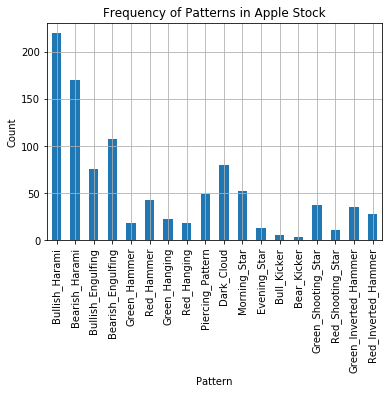

In [80]:
%matplotlib inline
ax = candlesticks_count.plot.bar()
ax.grid()
ax.set_xlabel('Pattern')
ax.set_ylabel('Count')
ax.set_title('Frequency of Patterns in Apple Stock')

This shows how some candlestick patterns can appear frequently but others are quite rare to find!

In [81]:
aapl.drop(['open','close','high','low','volume','date','SMA','trend'],axis=1).sum().sum()

994

A total of 994 candlestick patterns have occured.

##### Prediction score:
let's define the prediction score to be the fraction of the times that the pattern correctly predicted a price change to the total number of times the pattern appeared. 

In [83]:
def get_prediction_score(data, candlestick_pattern: str):
    '''
    takes in a dataframe and the name of a candlestick pattern and calculates the fraction of times the candlestick patter
    managed to predict the market correctly
    '''
    initial_prices = data['close'][data[candlestick_pattern]==1]
    next_price_point = data['close'][data[candlestick_pattern].shift(1)==1]
    price_increased = next_price_point.reset_index(drop=True) > initial_prices.reset_index(drop=True)
    price_dropped = next_price_point.reset_index(drop=True) < initial_prices.reset_index(drop=True)
    if candlestick_pattern in ['Bullish_Harami', 'Bullish_Engulfing', 'Green_Hammer', 'Red_Hammer', 'Piercing_Pattern',
                               'Morning_Star', 'Bull_Kicker', 'Green_Inverted_Hammer', 'Red_Inverted_Hammer']:
        prediction_score = price_increased.sum()/len(price_increased)
        return prediction_score
    # elif used rather than else to prevent typos to misclassify bullish and bearish signals
    elif candlestick_pattern in ['Bearish_Harami', 'Bearish_Engulfing', 'Green_Hanging', 'Red_Hanging', 'Dark_Cloud',
                                 'Evening_Star', 'Bear_Kicker', 'Green_Shooting_Star', 'Red_Shooting_Star']:
        prediction_score = price_dropped.sum()/len(price_dropped)
        return prediction_score
    else:
        print(f'Sorry, {candlestick_pattern} was not found in our list of modeled candlestick pattern ')
        

In [84]:
scores = pd.Series()
candlesticks = ['Bullish_Harami', 'Bearish_Harami','Bullish_Engulfing', 'Bearish_Engulfing','Green_Hammer', 'Red_Hammer',
                    'Green_Hanging', 'Red_Hanging','Piercing_Pattern', 'Dark_Cloud', 'Morning_Star','Evening_Star',
                    'Bull_Kicker', 'Bear_Kicker', 'Green_Shooting_Star', 'Red_Shooting_Star',
                    'Green_Inverted_Hammer', 'Red_Inverted_Hammer' ]
for pattern in candlesticks:
    scores[pattern] = get_prediction_score(aapl, pattern)

## Evaluating The Results
Now it's time to look at the prediction score of each pattern and see if we can rely on them for trading!

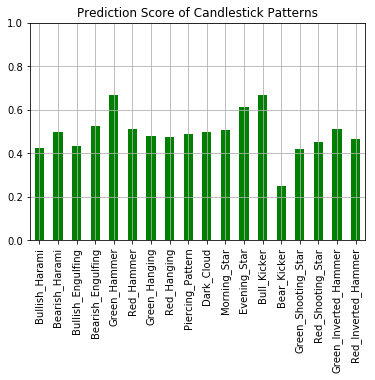

In [85]:
ax = scores.plot.bar(color='green')
ax.set_title('Prediction Score of Candlestick Patterns')
ax.set_ylim(0,1)
ax.grid()

The higher the prediction score, the more reliable the candlestick pattern is. 

## Important Note:
You might think, there is a big bias in the scores that are plotted above. Since the price of the Apple stock has had an uptrend since the initial public offering, there should have been more bullish days than bearish days. Thus if you choose a random day in the history of the stock, it is more likely that the price will be higher the next day. In other words, the bullish signals have an unfair advantage in our scoring system. That is a fair assumption. Let's check this together

In [86]:
def get_bullish_fraction(data):
    '''takes in a dataframe and returns the ratio of days where close price has increased'''
    bullish_days = data['close'] > data['close'].shift(1)
    return bullish_days.sum()/len(data)

Bullish_day_fraction 0.493


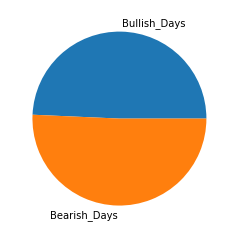

In [87]:
bullish_fraction = get_bullish_fraction(aapl)
plt.pie([bullish_fraction, 1-bullish_fraction], labels=['Bullish_Days','Bearish_Days'])
print('Bullish_day_fraction', np.round(bullish_fraction,3))

Well I guess that is not what you expected. The number of bullish and bearish days are close to the number of bearish days. One explanation for this could be that the magnitude of price gains were higher than the magnitude of drops on average, thus the stock has gained over time despite having fewere bullish days. Don't want to go off-topic, but let's check this out quickly.

In [88]:
where_loss_happened = aapl['close'] > aapl['close'].shift(-1)
price_losses = aapl['close'][where_loss_happened].reset_index(drop=True) - aapl['close'][where_loss_happened.shift(1).fillna(False)].reset_index(drop=True)
abs(np.mean(price_losses))

0.33619826242952683

In [89]:
where_gain_happened = aapl['close'] < aapl['close'].shift(-1)
price_gains = aapl['close'][where_gain_happened].reset_index(drop=True) - aapl['close'][where_gain_happened.shift(1).fillna(False)].reset_index(drop=True)
abs(np.mean(price_gains))

0.36221668832363624

As you can see, the average daily gain is higher than average daily loss. 

Now let's write a function to correct the prediction scores of each candlestick patterns

In [90]:
def correct_prediction_score(data, candlestick_pattern: str):
    '''
    Takes in a dataframe and the name of a candlestick pattern and returns a new accuracy score which is corrected
    based on the ratio of bullish to bearish days
    '''
    bullish_fraction = get_bullish_fraction(data)
    initial_prices = data['close'][data[candlestick_pattern]==1]
    next_price_point = data['close'][data[candlestick_pattern].shift(1)==1]
    price_increased = next_price_point.reset_index(drop=True) > initial_prices.reset_index(drop=True)
    price_dropped = next_price_point.reset_index(drop=True) < initial_prices.reset_index(drop=True)
    if candlestick_pattern in ['Bullish_Harami', 'Bullish_Engulfing', 'Green_Hammer', 'Red_Hammer', 'Piercing_Pattern',
                               'Morning_Star', 'Bull_Kicker', 'Green_Inverted_Hammer', 'Red_Inverted_Hammer']:
        prediction_score = price_increased.sum()/len(price_increased)
        prediction_score *= 0.5/bullish_fraction
        return prediction_score
    # elif used rather than else to prevent typos to misclassify bullish and bearish signals
    elif candlestick_pattern in ['Bearish_Harami', 'Bearish_Engulfing', 'Green_Hanging', 'Red_Hanging', 'Dark_Cloud',
                                 'Evening_Star', 'Bear_Kicker', 'Green_Shooting_Star', 'Red_Shooting_Star']:
        prediction_score = price_dropped.sum()/len(price_dropped)
        prediction_score *= 0.5/(1-bullish_fraction)
        return prediction_score
    else:
        print(f'Sorry, {candlestick_pattern} was not found in our list of modeled candlestick pattern ')
        

In [91]:
corrected_scores = pd.Series()
for pattern in candlesticks:
    corrected_scores[pattern] = correct_prediction_score(aapl, pattern)
    

Text(0.5, 1.0, 'Score of patterns in Apple stock')

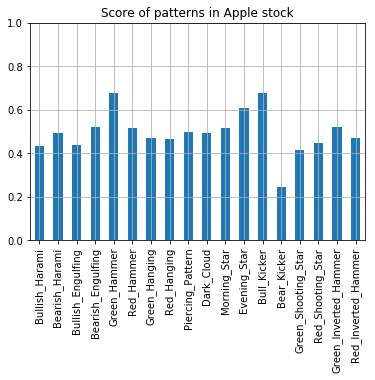

In [92]:
ax = corrected_scores.plot.bar()
ax.set_ylim(0,1)
ax.grid()
ax.set_title('Score of patterns in Apple stock')

#### Analysis
First we need to understand the scoring system. A score of 1 is the perfect score and it means that whenever the pattern has appeared, the market trend has changed in the way that the pattern predicts, e.g. if bullish kicker had a score of 1, it would mean that every time the pattern had been observed, the next candle was bullish. 

On the other hand, a score of 0 means the worst possible score, and it means that the candle has made the wrong prediction every single time. 

The middle ground is the score of 0.5, which is the score that you would get if you were to randomly guess the trend of the market. Basically this means you are right half of the time. 

Looking at the data, we observe that most of the candles seem to have a score of roughly 0.5, which means that they do not offer any predictive power whatsoever. 
In the example of Bull kicker and Bear kicker patterns, the number of observations is too low to make a judgement. Maybe it would help if we repeated the same analysis on more stock data to increase the number of our observations and make a better judgement. Let's do it!

In [93]:
def analyze_candlestick_accuracy(data, stock_name:str):
    '''
    Does all the above mentioned analysis and plots the frequency and corrected score of the patterns
    '''
    data = data.sort_values('date')
    data = data.reset_index(drop=True)
    data = data.drop(['adjclose'],axis=1)
    data['trend'] = find_trend(data, 3)
    data['Bullish_Harami'] = find_bullish_harami(data)
    data['Bearish_Harami'] = find_bearish_harami(data)
    data['Bullish_Engulfing'] = find_bullish_engulfing(data)
    data['Bearish_Engulfing'] = find_bearish_engulfing(data)
    data['Green_Hammer'] = find_green_hammer(data)
    data['Red_Hammer'] = find_red_hammer(data)
    data['Green_Hanging'] = find_green_hanging(data)
    data['Red_Hanging'] = find_red_hanging(data)
    data['Piercing_Pattern'] = find_piercing_pattern(data)
    data['Dark_Cloud'] = find_dark_cloud(data)
    data['Morning_Star'] = find_morning_star(data)
    data['Evening_Star'] = find_evening_star(data)
    data['Bull_Kicker'] = find_bull_kicker(data)
    data['Bear_Kicker'] = find_bear_kicker(data)
    data['Green_Shooting_Star'] = find_green_shooting_star(data)
    data['Red_Shooting_Star'] = find_red_shooting_star(data)
    data['Green_Inverted_Hammer'] = find_green_inverted_hammer(data)
    data['Red_Inverted_Hammer'] = find_red_inverted_hammer(data)
    
    candlesticks_count = data.drop(['open','close','high','low','volume','date','SMA','trend'],axis=1).sum()
    ax1 = candlesticks_count.plot.bar()
    ax1.grid()
    ax1.set_xlabel('Pattern')
    ax1.set_ylabel('Count')
    ax1.set_title(stock_name)
    candlesticks = ['Bullish_Harami', 'Bearish_Harami','Bullish_Engulfing', 'Bearish_Engulfing','Green_Hammer', 'Red_Hammer',
                    'Green_Hanging', 'Red_Hanging','Piercing_Pattern', 'Dark_Cloud', 'Morning_Star','Evening_Star',
                    'Bull_Kicker', 'Bear_Kicker', 'Green_Shooting_Star', 'Red_Shooting_Star',
                    'Green_Inverted_Hammer', 'Red_Inverted_Hammer' ]
    corrected_scores = pd.Series()
    for pattern in candlesticks:
        corrected_scores[pattern] = correct_prediction_score(data, pattern)
    return corrected_scores


In [94]:
def plot_scores(corrected_scores, stock_name:str):
    ax = corrected_scores.plot.bar(color='green')
    ax.set_ylim(0,1)
    ax.set_title(stock_name)
    ax.grid()
    

In [95]:
Amazon = pd.read_csv('AMZN.csv')

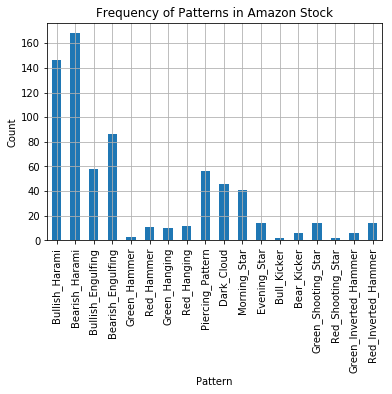

In [96]:
corrected_scores_amzn = analyze_candlestick_accuracy(Amazon, 'Frequency of Patterns in Amazon Stock')

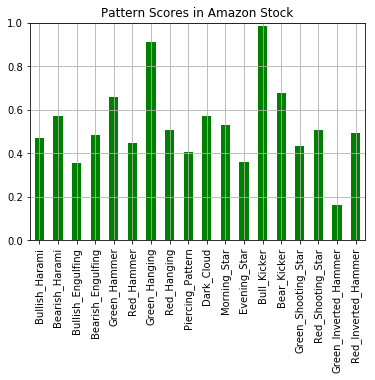

In [97]:
plot_scores(corrected_scores_amzn, 'Pattern Scores in Amazon Stock')

This is absolutely interesting! Look at the count of each pattern. The patterns that appear more often seem to score closer to 0.5, which is the equivalent of randomly trading. Let's do the process for other stocks!

In [98]:
nflx = pd.read_csv('NFLX.csv')

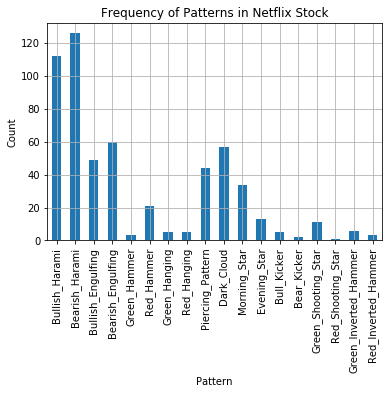

In [99]:
corrected_scores_nflx = analyze_candlestick_accuracy(nflx, 'Frequency of Patterns in Netflix Stock')

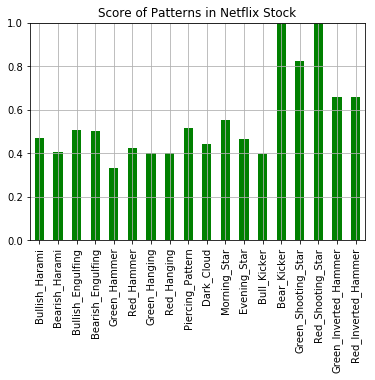

In [100]:
plot_scores(corrected_scores_nflx, 'Score of Patterns in Netflix Stock')

#### The correlation is observed again, if the number of observations increases, the score approaches 0.5, which is the equivalent of randomly trading

This is a clear proof that candlestick patterns by themselves cannot be reliable indicators for future market trends. While there is value in looking at candlestick patterns to understand the market better, they should not be treated as trustworthy indicators of market movement. 


disclaimer: This post by no means is providing financial advice to anyone, and is merely a statistical analysis of how well candlestick patterns have been able to predict the market